In [27]:
# Import necessary modules
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import hashlib
import os
from datetime import date
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from xbbg import blp
import keras_tuner as kt
import shutil

# Set visualization style
sns.set_style('whitegrid')
%matplotlib inline




In [2]:
# User input for equity and dates
tickers = input("Enter the Equity name. eg: AAPL US Equity\n")
commands = "PX_LAST, PX_HIGH, PX_LOW, PX_VOLUME, TWITTER_SENTIMENT, TWITTER_NEG_SENTIMENT_COUNT, TWITTER_POS_SENTIMENT_COUNT, TWITTER_NEUTRAL_SENTIMENT_CNT, TWITTER_PUBLICATION_COUNT,NEWS_POS_SENTIMENT_COUNT, NEWS_NEG_SENTIMENT_COUNT, NEWS_NEUTRAL_SENTIMENT_COUNT, NEWS_PUBLICATION_COUNT"


Enter the Equity name. eg: AAPL US Equity
 AAPL US Equity


In [3]:
start = input("Enter the start date in YYYY-MM-DD format\n")
a = input("Type YES if you want current date as end date or no for custom date\n")

if a.upper() == "YES":
    end = str(date.today())
else:
    end = str(input("Enter the end date in YYYY-MM-DD format\n"))

# Create a unique filename based on inputs
filename = hashlib.md5(''.join((tickers, "+", commands, "+", start, "+", end)).encode('utf-8')).hexdigest()

# Load or fetch data
if os.path.exists(filename + '.csv'):
    data = pd.read_csv(filename + ".csv", header=[0, 1], parse_dates=True, index_col=0)
else:
    data = blp.bdh(tickers=tickers.split(', '), flds=commands.split(', '), start_date=start, end_date=end, Per='D', Fill='P', Days='A', adjust='all')
    data.to_csv(filename + ".csv")

df = data[tickers]


Enter the start date in YYYY-MM-DD format
 2016-05-02
Type YES if you want current date as end date or no for custom date
 YES


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3023 entries, 2016-05-02 to 2024-08-10
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   PX_LAST                        3023 non-null   float64
 1   PX_HIGH                        3023 non-null   float64
 2   PX_LOW                         3023 non-null   float64
 3   PX_VOLUME                      3023 non-null   float64
 4   TWITTER_NEG_SENTIMENT_COUNT    3023 non-null   float64
 5   TWITTER_POS_SENTIMENT_COUNT    3023 non-null   float64
 6   TWITTER_NEUTRAL_SENTIMENT_CNT  3023 non-null   float64
 7   NEWS_NEG_SENTIMENT_COUNT       3023 non-null   float64
 8   NEWS_NEUTRAL_SENTIMENT_COUNT   3023 non-null   float64
 9   NEWS_PUBLICATION_COUNT         3023 non-null   float64
dtypes: float64(10)
memory usage: 259.8+ KB


In [5]:
df

,PX_LAST,PX_HIGH,PX_LOW,PX_VOLUME,TWITTER_NEG_SENTIMENT_COUNT,TWITTER_POS_SENTIMENT_COUNT,TWITTER_NEUTRAL_SENTIMENT_CNT,NEWS_NEG_SENTIMENT_COUNT,NEWS_NEUTRAL_SENTIMENT_COUNT,NEWS_PUBLICATION_COUNT
2016-05-02,21.372,21.472,21.089,192640416.0,470.0,309.0,3464.0,17.0,103.0,948.0
2016-05-03,21.723,21.851,21.381,227325108.0,1332.0,457.0,6986.0,90.0,324.0,2103.0
2016-05-04,21.497,21.887,21.413,164101900.0,1816.0,531.0,10240.0,113.0,485.0,2755.0
2016-05-05,21.410,21.601,21.281,143562000.0,1199.0,209.0,7355.0,88.0,429.0,2323.0
2016-05-06,21.291,21.458,21.091,174799544.0,734.0,233.0,9651.0,68.0,509.0,2552.0
...,...,...,...,...,...,...,...,...,...,...
2024-08-06,207.230,209.990,201.070,69660488.0,93.0,15.0,323.0,152.0,281.0,1350.0
2024-08-07,209.820,213.640,206.390,63516417.0,63.0,8.0,270.0,53.0,166.0,966.0
2024-08-08,213.310,214.200,208.830,47161149.0,27.0,8.0,192.0,10.0,168.0,1068.0
2024-08-09,216.240,216.780,211.970,42201646.0,23.0,4.0,234.0,13.0,184.0,1033.0


In [6]:
# Define technical indicators
def get_technical_indicators(dataset):
    dataset['ma7'] = dataset['PX_LAST'].rolling(window=7).mean()
    dataset['ma21'] = dataset['PX_LAST'].rolling(window=21).mean()
    dataset['26ema'] = dataset['PX_LAST'].ewm(span=26).mean()
    dataset['12ema'] = dataset['PX_LAST'].ewm(span=12).mean()
    dataset['MACD'] = dataset['12ema'] - dataset['26ema']
    dataset['20sd'] = dataset['PX_LAST'].rolling(20).std()
    dataset['upper_band'] = dataset['ma21'] + (dataset['20sd'] * 2)
    dataset['lower_band'] = dataset['ma21'] - (dataset['20sd'] * 2)
    dataset['ema'] = dataset['PX_LAST'].ewm(com=0.5).mean()
    dataset['momentum'] = dataset['PX_LAST'] - 1
    return dataset

ti_df = get_technical_indicators(df[['PX_LAST']].copy()).fillna(method='bfill')
ti_df.index = pd.DatetimeIndex(df.index)

ti_df

C:\Users\bs23895.QM\AppData\Local\Temp\ipykernel_9024\3942176261.py:15: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ti_df = get_technical_indicators(df[['PX_LAST']].copy()).fillna(method='bfill')


,PX_LAST,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum
2016-05-02,21.372,21.410714,21.377905,21.372000,21.372000,0.000000,0.349495,22.113451,20.642359,21.372000,20.372
2016-05-03,21.723,21.410714,21.377905,21.554250,21.562125,0.007875,0.349495,22.113451,20.642359,21.635250,20.723
2016-05-04,21.497,21.410714,21.377905,21.533681,21.536707,0.003026,0.349495,22.113451,20.642359,21.539538,20.497
2016-05-05,21.410,21.410714,21.377905,21.499105,21.496710,-0.002395,0.349495,22.113451,20.642359,21.452100,20.410
2016-05-06,21.291,21.410714,21.377905,21.450845,21.440820,-0.010025,0.349495,22.113451,20.642359,21.344256,20.291
...,...,...,...,...,...,...,...,...,...,...,...
2024-08-06,207.230,216.645714,219.925238,219.037942,216.808547,-2.229395,4.697463,229.320164,210.530313,209.083998,206.230
2024-08-07,209.820,214.894286,219.017619,218.355132,215.733386,-2.621745,5.026772,229.071163,208.964075,209.574666,208.820
2024-08-08,213.310,214.172857,218.500000,217.981418,215.360558,-2.620861,4.989142,228.478285,208.521715,212.064889,212.310
2024-08-09,216.240,213.655714,218.115714,217.852424,215.495856,-2.356568,4.792241,227.700196,208.531233,214.848296,215.240


In [7]:
# Prepare data for modeling
target_column = ['PX_LAST']
predictors = list(set(df.columns) - set(target_column))

# Scale data
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

X = scaler_X.fit_transform(df[predictors])
y = scaler_y.fit_transform(df[target_column].values.reshape(-1, 1))



In [10]:
# Split data
split_index = int(len(df) * 0.7)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Reshape for LSTM and GRU
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))



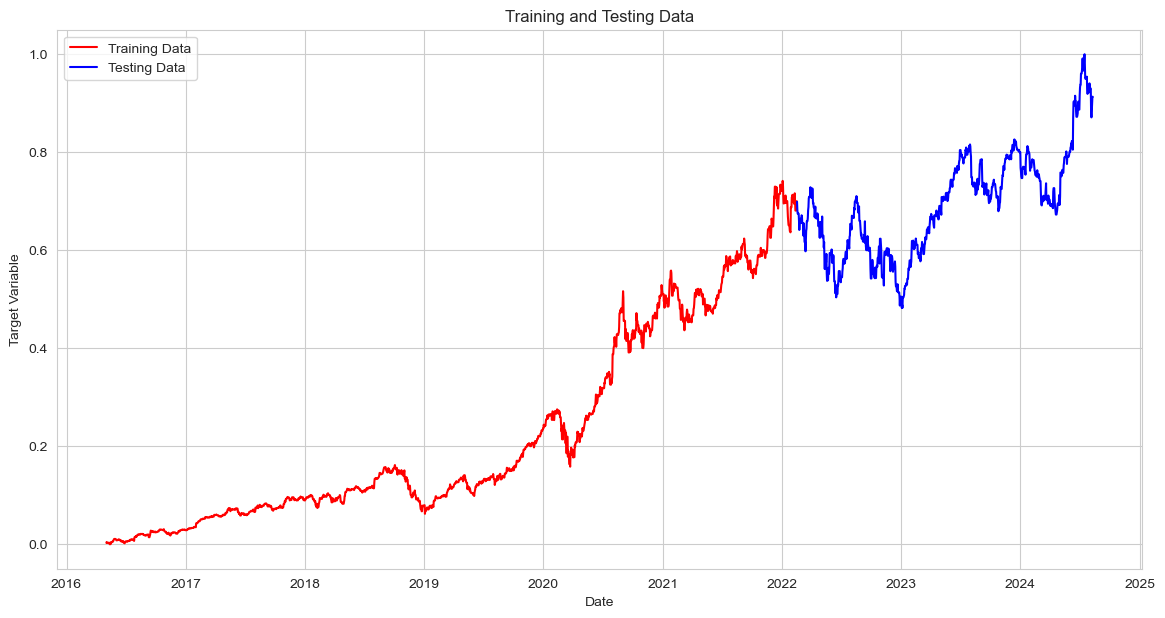

In [20]:
train_dates = df.index[:split_index]
test_dates = df.index[split_index:]

# Plotting the training data
plt.figure(figsize=(14, 7))
plt.plot(train_dates, y_train, color='#ff0000', label='Training Data')

# Plotting the testing data
plt.plot(test_dates, y_test, color='#0000ff', label='Testing Data')

# Adding titles and labels
plt.title('Training and Testing Data')
plt.xlabel('Date')
plt.ylabel('Target Variable')

# Showing the legend
plt.legend()

# Display the plot
plt.show()

In [12]:
# Define the LSTM model
def create_lstm(X_train, regress=False):
    model = Sequential()
    model.add(LSTM(units=32, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(units=128, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=512))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    return model

In [13]:
modelName = "./LSTM"
if not os.path.exists(modelName + "/model.h5"):
    model_lstm = create_lstm(X_train, regress=False)
    model_lstm.compile(loss='mae', optimizer='adam')
    history_lstm = model_lstm.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), shuffle=False)
    scores_lstm = model_lstm.evaluate(X_train, y_train, verbose=0)
    model_lstm.save(modelName + ".weights.h5")
    model_lstm.save_weights(modelName + "model.weights.h5")
else:
    model_lstm = load_model(modelName+ ".weights.h5")
    model_lstm.load_weights(modelName + 'model.weights.h5')
    model_lstm.compile(loss='mae', optimizer='adam')
    scores_lstm = model_lstm.evaluate(X_train, y_train, verbose=0)
 
print(model_lstm.summary())
print('')

Epoch 1/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0230 - val_loss: 0.0820
Epoch 2/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2778 - val_loss: 0.0993
Epoch 3/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3544 - val_loss: 0.0659
Epoch 4/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2360 - val_loss: 0.0431
Epoch 5/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0698 - val_loss: 0.0217
Epoch 6/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0443 - val_loss: 0.0176
Epoch 7/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0573 - val_loss: 0.0188
Epoch 8/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0278 - val_loss: 0.0187
Epoch 9/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0234 - val_loss: 0.0280
Epoch 10/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0308 - val_loss: 0.0280
Epoch 11/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0294 - val_loss: 0.0234
Epoch 12/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 1, 32)          │         5,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 1, 128)         │        82,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 512)            │     1,312,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,203,269 (16.03 MB)

 Trainable params: 1,401,089 (5.34 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,802,180 (10.69 MB)

None



In [14]:
# Define the GRU model
def create_gru(X_train, regress=False):
    model = Sequential()
    model.add(GRU(units=32, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(GRU(units=128, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(GRU(units=512))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    return model

In [15]:
modelName = "./GRU"
if not os.path.exists(modelName+"/model.h5"):
    model_gru = create_gru(X_train, regress=False)
    model_gru.compile(loss = 'mae', optimizer = 'adam')
    history_gru = model_gru.fit(X_train, y_train, epochs = 15,batch_size=32, validation_data = (X_test, y_test), shuffle=False)
    scores_gru = model_gru.evaluate(X_train, y_train, verbose=0)
    model_gru.save(modelName + ".weights.h5")
    # serialize weights to HDF5
    model_gru.save_weights(modelName+"model.weights.h5")
else:    
    model_gru = load_model(modelName + ".weights.h5")
    model_gru.load_weights(modelName+'model.weights.h5')
    results_gru = model_gru.compile(loss = 'mae', optimizer = 'adam')
    history_gru = model_gru.fit(X_train, y_train, epochs = 15,batch_size=32, validation_data = (X_test, y_test), shuffle=False)
    scores_gru= model_gru.evaluate(X_train, y_train, verbose=0)

print(model_gru.summary())
print('')


Epoch 1/15
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0214 - val_loss: 0.0703
Epoch 2/15
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2281 - val_loss: 0.0587
Epoch 3/15
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2000 - val_loss: 0.0724
Epoch 4/15
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2323 - val_loss: 0.0647
Epoch 5/15
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1919 - val_loss: 0.0446
Epoch 6/15
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1326 - val_loss: 0.0208
Epoch 7/15
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0567 - val_loss: 0.0182
Epoch 8/15
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0429 - val_loss: 0.0534
Epoch 9/15
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0260 - val_loss: 0.0202
Epoch 10/15
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0304 - val_loss: 0.0132
Epoch 11/15
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0169 - val_loss: 0.0189
Epoch 12/15
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0181 - val_l

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 1, 32)          │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 1, 128)         │        62,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 512)            │       986,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,158,885 (12.05 MB)

 Trainable params: 1,052,961 (4.02 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,105,924 (8.03 MB)

None



In [16]:
# Metrics evaluation
def evalModel(forecast):
    forecast_tensor = tf.convert_to_tensor(forecast, dtype=tf.float32)
    y_test_tensor = tf.convert_to_tensor(y_test, dtype=tf.float32)
    
    mse_metric = tf.keras.metrics.MeanSquaredError()
    mae_metric = tf.keras.metrics.MeanAbsoluteError()
    
    mse_metric.update_state(y_test_tensor, forecast_tensor)
    mae_metric.update_state(y_test_tensor, forecast_tensor)
    
    mse = mse_metric.result().numpy()
    mae = mae_metric.result().numpy()
    
    return mse, mae

def addMetrics(metricsDF, modelName, forecast):
    mse, mae = evalModel(forecast)
    metricsDF.loc[modelName] = [mse, mae]
    return metricsDF

metricsDF = pd.DataFrame(columns=['MSE', 'MAE'])


In [21]:
metricsDF

,MSE,MAE
LSTM prediction,28482.218750,168.045715
GRU prediction,29022.597656,168.863998


29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


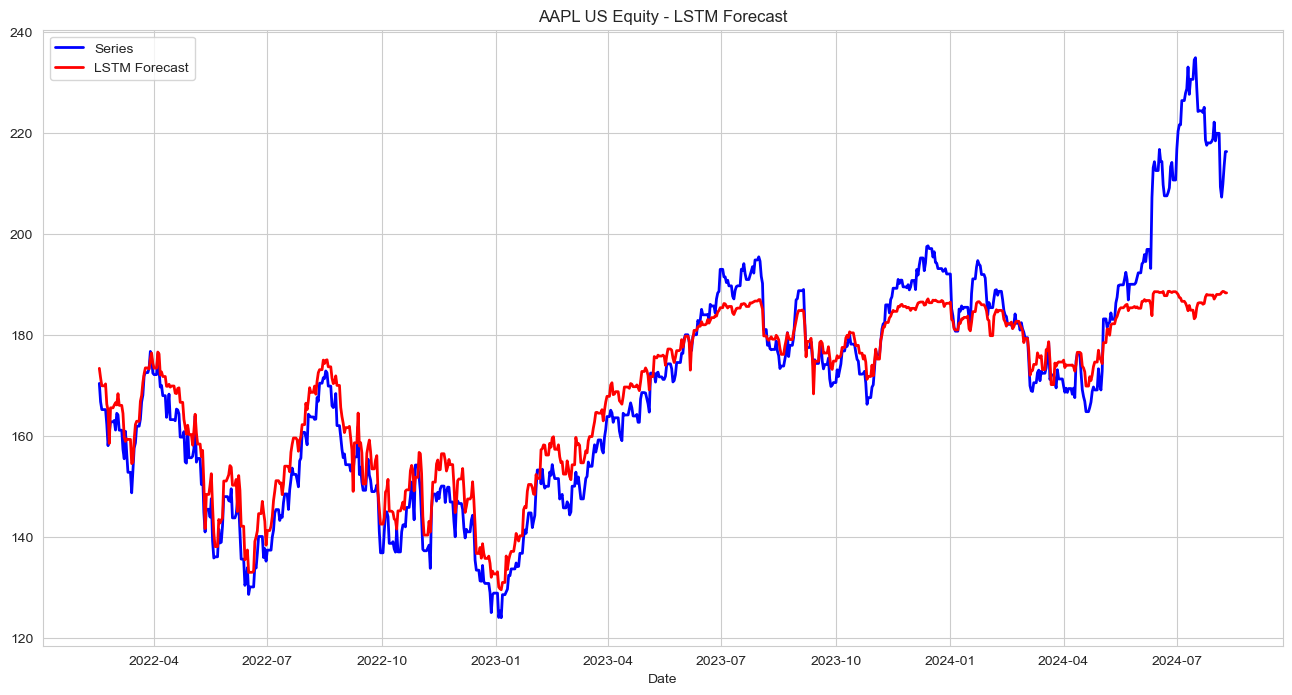

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step 


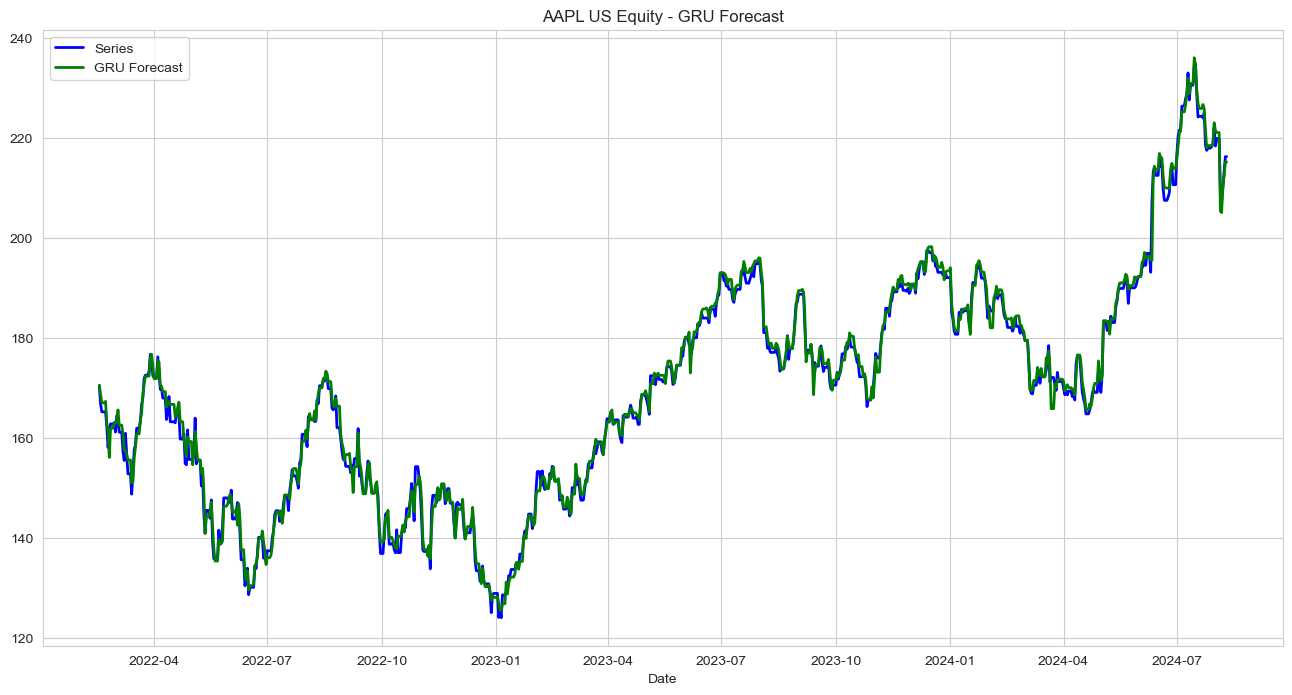

                          MSE         MAE
LSTM prediction  28482.218750  168.045715
GRU prediction   29022.597656  168.863998


In [17]:
# Make predictions and plot results
y_predicted_lstm = model_lstm.predict(X_test)
y_predicted_lstm = scaler_y.inverse_transform(y_predicted_lstm)
y_predicted_lstm = pd.DataFrame(y_predicted_lstm)

plt.figure(figsize=(16,8))
plt.xlabel('Date')
plt.plot(df.index[split_index:], df['PX_LAST'][split_index:], lw=2, c='blue')
plt.plot(df.index[split_index:], y_predicted_lstm, lw=2, c='red')
plt.legend(['Series', 'LSTM Forecast'])
plt.title(tickers + ' - LSTM Forecast')
plt.grid(True)
plt.show()

addMetrics(metricsDF, "LSTM prediction", y_predicted_lstm.values.reshape(-1))

y_predicted_gru = model_gru.predict(X_test)
y_predicted_gru = scaler_y.inverse_transform(y_predicted_gru)
y_predicted_gru = pd.DataFrame(y_predicted_gru)

plt.figure(figsize=(16,8))
plt.xlabel('Date')
plt.plot(df.index[split_index:], df['PX_LAST'][split_index:], lw=2, c='blue')
plt.plot(df.index[split_index:], y_predicted_gru, lw=2, c='green')
plt.legend(['Series', 'GRU Forecast'])
plt.title(tickers + ' - GRU Forecast')
plt.grid(True)
plt.show()

addMetrics(metricsDF, "GRU prediction", y_predicted_gru.values.reshape(-1))

# Show metrics
print(metricsDF)

In [28]:
# Remove old directory if it exists
shutil.rmtree('my_dir/lstm_tuning', ignore_errors=True)

In [40]:
dfname=tickers

In [29]:
#Hyperparameter optimisation
def build_lstm_model(hp):
    model = Sequential()
    # Tune the number of units in the first LSTM layer
    model.add(LSTM(units=hp.Int('units_1', min_value=32, max_value=512, step=32), activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    # Tune the number of units in the second LSTM layer
    model.add(LSTM(units=hp.Int('units_2', min_value=32, max_value=512, step=32), return_sequences=True))
    model.add(Dropout(0.2))
    # Tune the number of units in the third LSTM layer
    model.add(LSTM(units=hp.Int('units_3', min_value=32, max_value=512, step=32)))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mae')
    return model
tuner = kt.RandomSearch(
    build_lstm_model,
    objective='val_loss',
    max_trials=5,  # The number of different hyperparameter combinations to try
    executions_per_trial=1,  # Number of models to build and fit for each trial
    directory='my_dir',
    project_name='lstm_tuning'
)

In [30]:
# Perform the hyperparameter search
tuner.search(X_train, y_train, epochs=100, validation_data=(X_test, y_test))
 
best_model = tuner.get_best_models(num_models=1)[0]

Trial 5 Complete [00h 00m 37s]
val_loss: 0.0059667122550308704

Best val_loss So Far: 0.005163311492651701
Total elapsed time: 00h 05m 06s


C:\Users\bs23895.QM\AppData\Local\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 24 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [31]:
# Remove old directory for GRU tuning
shutil.rmtree('my_dir/gru_tuning', ignore_errors=True)

In [33]:
# Evaluate tuned GRU model
y_predicted_lstm = best_model.predict(X_test)
y_predicted_lstm = scaler_y.inverse_transform(y_predicted_lstm)
y_predicted_lstm = pd.DataFrame(y_predicted_lstm, index=df.index[split_index:])


29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


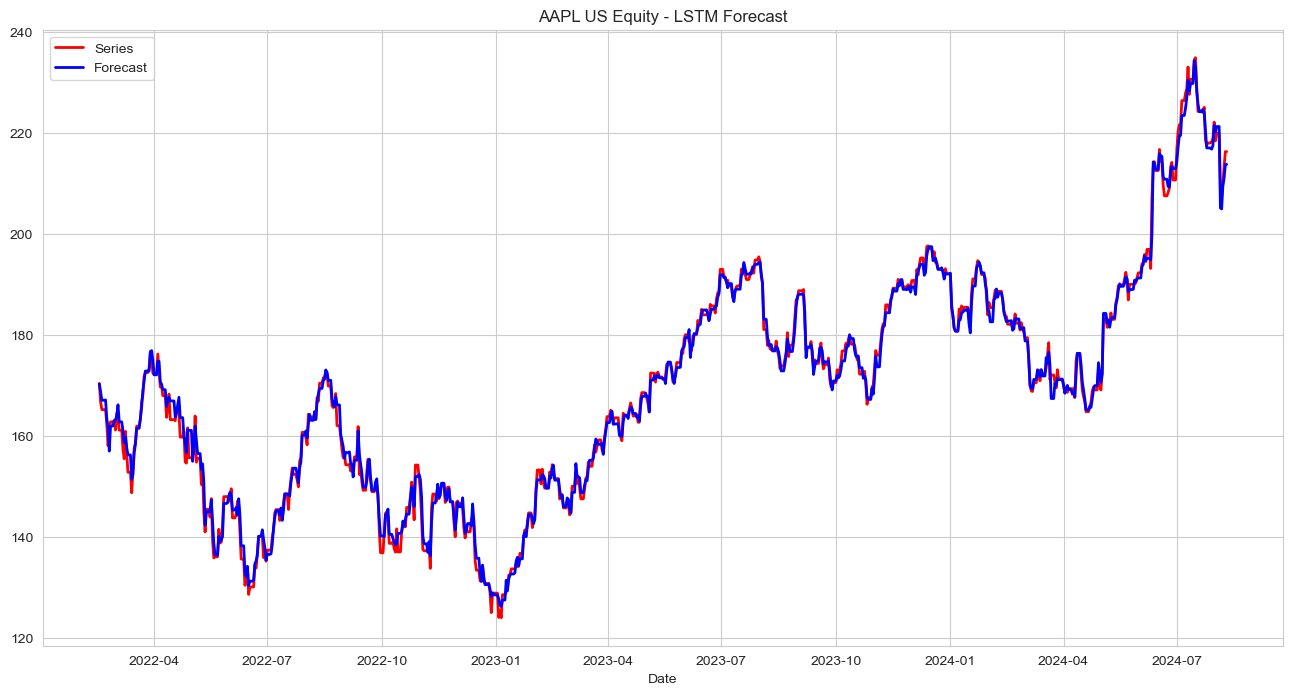

In [41]:
plt.figure(figsize=(16,8))
plt.xlabel('Date')
plt.plot(df['PX_LAST'][split_index:], lw=2, c='red')
plt.plot(df['PX_LAST'][split_index:].index, y_predicted_lstm, lw=2, c='blue')
plt.legend(['Series', 'Forecast'])
plt.title(dfname+' - LSTM Forecast')
plt.grid(True)
plt.show()

In [42]:
shutil.rmtree('my_dir/lstm_tuning', ignore_errors=True)

In [44]:
addMetrics(metricsDF, "LSTM prediction",y_predicted_lstm.values.reshape(-1))
metricsDF

,MSE,MAE
LSTM prediction,28890.541016,168.547867
GRU prediction,29022.597656,168.863998


In [45]:
def build_gru_model(hp):
    model = Sequential()
    # Tune the number of units in the first GRU layer
    model.add(GRU(units=hp.Int('units_1', min_value=32, max_value=512, step=32), activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    # Tune the number of units in the second GRU layer
    model.add(GRU(units=hp.Int('units_2', min_value=32, max_value=512, step=32), return_sequences=True))
    model.add(Dropout(0.2))
    # Tune the number of units in the third GRU layer
    model.add(GRU(units=hp.Int('units_3', min_value=32, max_value=512, step=32)))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mae')
    return model

tuner = kt.RandomSearch(
    build_gru_model,
    objective='val_loss',
    max_trials=5,  # The number of different hyperparameter combinations to try
    executions_per_trial=1,  # Number of models to build and fit for each trial
    directory='my_dir',
    project_name='gru_tuning'
)

# Perform the hyperparameter search
tuner.search(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

best_model = tuner.get_best_models(num_models=1)[0]

Trial 5 Complete [00h 01m 06s]
val_loss: 0.006790078245103359

Best val_loss So Far: 0.005587232299149036
Total elapsed time: 00h 04m 57s


C:\Users\bs23895.QM\AppData\Local\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 24 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [46]:
# Remove old directory for GRU tuning
shutil.rmtree('my_dir/gru_tuning', ignore_errors=True)

In [47]:
# Evaluate tuned GRU model
y_predicted_gru = best_model.predict(X_test)
y_predicted_gru = scaler_y.inverse_transform(y_predicted_gru)
y_predicted_gru = pd.DataFrame(y_predicted_gru, index=df.index[split_index:])


29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


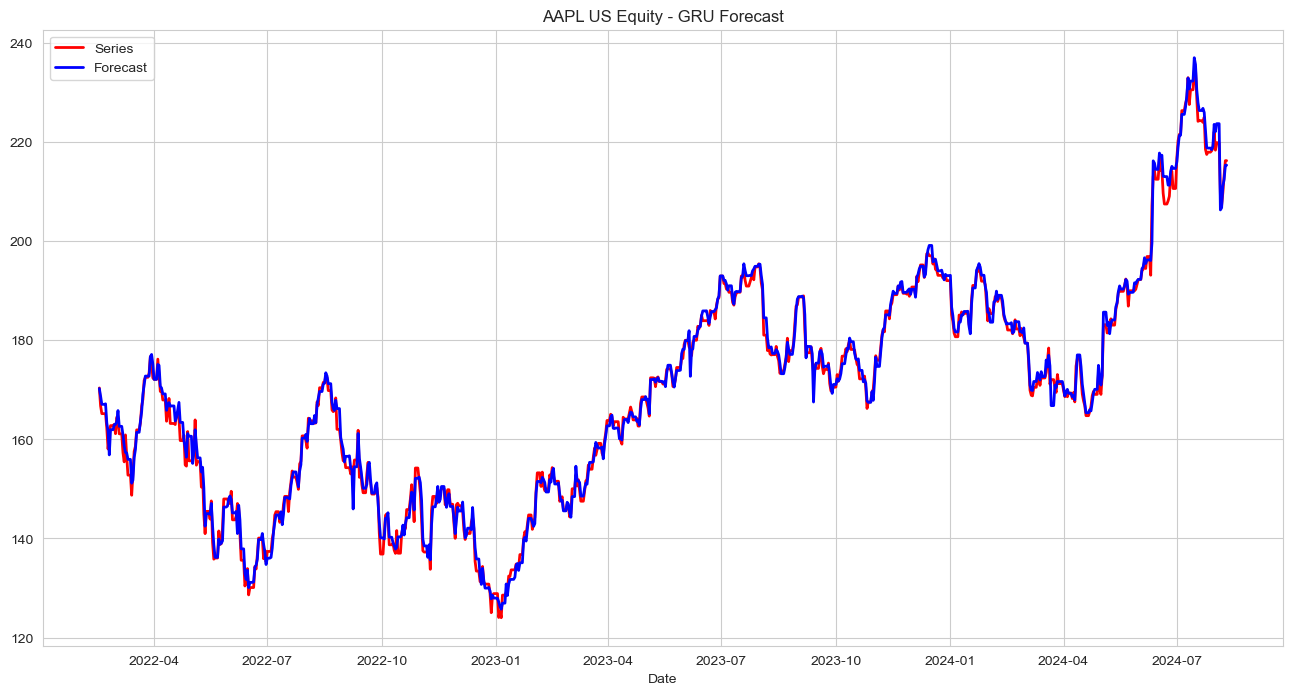

In [50]:
plt.figure(figsize=(16,8))
plt.xlabel('Date')
plt.plot(df['PX_LAST'][split_index:], lw=2, c='red')
plt.plot(df['PX_LAST'][split_index:].index, y_predicted_gru, lw=2, c='blue')
plt.legend(['Series', 'Forecast'])
plt.title(dfname+' - GRU Forecast')
plt.grid(True)
plt.show()

In [51]:
addMetrics(metricsDF, "GRU prediction",y_predicted_gru.values.reshape(-1))
metricsDF

,MSE,MAE
LSTM prediction,28890.541016,168.547867
GRU prediction,29024.611328,168.858734


In [52]:
!pip install yfinance

     ---------------------------------------- 0.0/3.0 MB ? eta -:--:--
     ---------------------------------------- 0.0/3.0 MB 1.3 MB/s eta 0:00:03
     - -------------------------------------- 0.1/3.0 MB 2.1 MB/s eta 0:00:02
     ---------------------------------------  2.9/3.0 MB 31.3 MB/s eta 0:00:01
     ---------------------------------------- 3.0/3.0 MB 27.0 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
   ---------------------------------------- 0.0/73.5 kB ? eta -:--:--
   ---------------------------------------- 73.5/73.5 kB ? eta 0:00:00
   ---------------------------------------- 0.0/112.2 kB ? eta -:--:--
   ---------------------------------------- 112.2/112.2 kB ? eta 0:00:00


In [53]:
!pip install xgboost

   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB 653.6 kB/s eta 0:03:12
   ---------------------------------------- 0.6/124.9 MB 5.1 MB/s eta 0:00:25
   - -------------------------------------- 3.4/124.9 MB 21.6 MB/s eta 0:00:06
   -- ------------------------------------- 6.7/124.9 MB 33.1 MB/s eta 0:00:04
   -- ------------------------------------- 9.4/124.9 MB 40.0 MB/s eta 0:00:03
   --- ------------------------------------ 11.8/124.9 MB 65.6 MB/s eta 0:00:02
   ---- ----------------------------------- 15.0/124.9 MB 65.6 MB/s eta 0:00:02
   ----- ---------------------------------- 17.8/124.9 MB 59.5 MB/s eta 0:00:02
   ------ --------------------------------- 20.7/124.9 MB 65.2 MB/s eta 0:00:02
   ------- -------------------------------- 24.0/124.9 MB 65.6 MB/s eta 0:00:02
   -------- ------------------------------- 27.2/124.9 MB 65.6 

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

from scipy import stats
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

%matplotlib inline

# Import the models
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor, BaggingRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')

In [55]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2116, 1, 9)
(2116, 1)
(907, 1, 9)
(907, 1)


In [56]:
print(X_train)
print(y_train)

[[[0.00256415 0.05416813 0.39639536 ... 0.04968112 0.03199751 0.07917442]]

 [[0.00393797 0.08019698 0.47794636 ... 0.12334184 0.10065238 0.22500423]]

 [[0.00408853 0.0932114  0.32929532 ... 0.16492347 0.15066791 0.30688547]]

 ...

 [[0.68396018 0.00175871 0.1754528  ... 0.15006378 0.06710158 0.00152259]]

 [[0.67708167 0.00158284 0.14609757 ... 0.09343112 0.02143523 0.00101506]]

 [[0.69422619 0.00140696 0.09460793 ... 0.13922194 0.04442373 0.00609034]]]
[[0.00293354]
 [0.00457314]
 [0.00351744]
 ...
 [0.68090304]
 [0.68201013]
 [0.70004578]]


In [57]:
df

,PX_LAST,PX_HIGH,PX_LOW,PX_VOLUME,TWITTER_NEG_SENTIMENT_COUNT,TWITTER_POS_SENTIMENT_COUNT,TWITTER_NEUTRAL_SENTIMENT_CNT,NEWS_NEG_SENTIMENT_COUNT,NEWS_NEUTRAL_SENTIMENT_COUNT,NEWS_PUBLICATION_COUNT
2016-05-02,21.372,21.472,21.089,192640416.0,470.0,309.0,3464.0,17.0,103.0,948.0
2016-05-03,21.723,21.851,21.381,227325108.0,1332.0,457.0,6986.0,90.0,324.0,2103.0
2016-05-04,21.497,21.887,21.413,164101900.0,1816.0,531.0,10240.0,113.0,485.0,2755.0
2016-05-05,21.410,21.601,21.281,143562000.0,1199.0,209.0,7355.0,88.0,429.0,2323.0
2016-05-06,21.291,21.458,21.091,174799544.0,734.0,233.0,9651.0,68.0,509.0,2552.0
...,...,...,...,...,...,...,...,...,...,...
2024-08-06,207.230,209.990,201.070,69660488.0,93.0,15.0,323.0,152.0,281.0,1350.0
2024-08-07,209.820,213.640,206.390,63516417.0,63.0,8.0,270.0,53.0,166.0,966.0
2024-08-08,213.310,214.200,208.830,47161149.0,27.0,8.0,192.0,10.0,168.0,1068.0
2024-08-09,216.240,216.780,211.970,42201646.0,23.0,4.0,234.0,13.0,184.0,1033.0


In [58]:
df_adj = df[['PX_LAST']]
df_adj 

,PX_LAST
2016-05-02,21.372
2016-05-03,21.723
2016-05-04,21.497
2016-05-05,21.410
2016-05-06,21.291
...,...
2024-08-06,207.230
2024-08-07,209.820
2024-08-08,213.310
2024-08-09,216.240


In [60]:
forecast_out = 30

# Create column for target variable shifted 'n' days up
df_adj['Prediction'] = df_adj[['PX_LAST']].shift(-forecast_out)

df_adj

,PX_LAST,Prediction
2016-05-02,21.372,22.609
2016-05-03,21.723,22.439
2016-05-04,21.497,22.485
2016-05-05,21.410,22.485
2016-05-06,21.291,22.485
...,...,...
2024-08-06,207.230,NaN
2024-08-07,209.820,NaN
2024-08-08,213.310,NaN
2024-08-09,216.240,NaN


In [61]:
X = np.array(df_adj.drop(['Prediction'],axis = 1))
# Remove last 'n' rows
X = X[:-forecast_out]

print(X)

[[ 21.372]
 [ 21.723]
 [ 21.497]
 ...
 [228.68 ]
 [232.98 ]
 [227.57 ]]


In [62]:
y = np.array(df_adj['Prediction'])
# Remove last 'n' rows
y = y[:-forecast_out]

print(y)

[ 22.609  22.439  22.485 ... 213.31  216.24  216.24 ]


In [63]:
train_size = int(X.shape[0]*0.7)

X_train = X[0:train_size]
y_train = y[0:train_size]

X_test = X[train_size:]
y_test = y[train_size:]

In [64]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2095, 1)
(2095,)
(898, 1)
(898,)


In [65]:
print(X_train)
print(y_train)

[[ 21.372]
 [ 21.723]
 [ 21.497]
 ...
 [160.154]
 [159.375]
 [157.56 ]]
[ 22.609  22.439  22.485 ... 162.244 158.047 160.684]


In [66]:
X_forecast = np.array(df_adj.drop(['Prediction'],axis = 1))[-forecast_out:]
print(X_forecast)

[[230.54]
 [230.54]
 [230.54]
 [234.4 ]
 [234.82]
 [228.88]
 [224.18]
 [224.31]
 [224.31]
 [224.31]
 [223.96]
 [225.01]
 [218.54]
 [217.49]
 [217.96]
 [217.96]
 [217.96]
 [218.24]
 [218.8 ]
 [222.08]
 [218.36]
 [219.86]
 [219.86]
 [219.86]
 [209.27]
 [207.23]
 [209.82]
 [213.31]
 [216.24]
 [216.24]]


In [67]:
models = {}

models["Linear"] = LinearRegression()
models["Lasso"] = Lasso()
models["Ridge"] = Ridge()
models["ElasticNet"] = ElasticNet()
models["KNN"] = KNeighborsRegressor()
models["DecisionTree"] = DecisionTreeRegressor()
models["SVR"] = SVR(kernel='rbf', C=1e3, gamma='scale')
models["AdaBoost"] = AdaBoostRegressor()
models["GradientBoost"] = GradientBoostingRegressor()
models["RandomForest"] = RandomForestRegressor()
models["ExtraTrees"]= ExtraTreesRegressor()
models["BaggingRegressor"] = BaggingRegressor()
models["XGBRegressor"] = XGBRegressor(objective ='reg:squarederror')
models["MLPRegressor"] = MLPRegressor(solver = 'lbfgs')
     

In [68]:
model_results = []  
model_names   = []
for model_name in models:
    model = models[model_name]
    # TimeSeries Cross validation
    tscv = TimeSeriesSplit(n_splits=7)
    
    cv_results = cross_val_score(model, X_train, y_train, cv=tscv, scoring='r2')
    model_results.append(cv_results)
    model_names.append(model_name)
    print("{}: {}, ({})".format(model_name, round(cv_results.mean(), 6), round(cv_results.std(), 6)))
     

Linear: 0.115405, (0.707193)
Lasso: -0.059671, (0.777969)
Ridge: 0.115429, (0.707178)
ElasticNet: -0.02027, (0.736221)
KNN: -2.776542, (2.364478)
DecisionTree: -3.110226, (2.563057)
SVR: -17.145266, (20.468811)
AdaBoost: -1.981096, (1.791742)
GradientBoost: -2.859567, (2.387496)
RandomForest: -3.001268, (2.500943)
ExtraTrees: -3.078813, (2.579723)
BaggingRegressor: -2.976705, (2.485451)
XGBRegressor: -2.606196, (2.303107)
MLPRegressor: 0.056423, (0.678624)


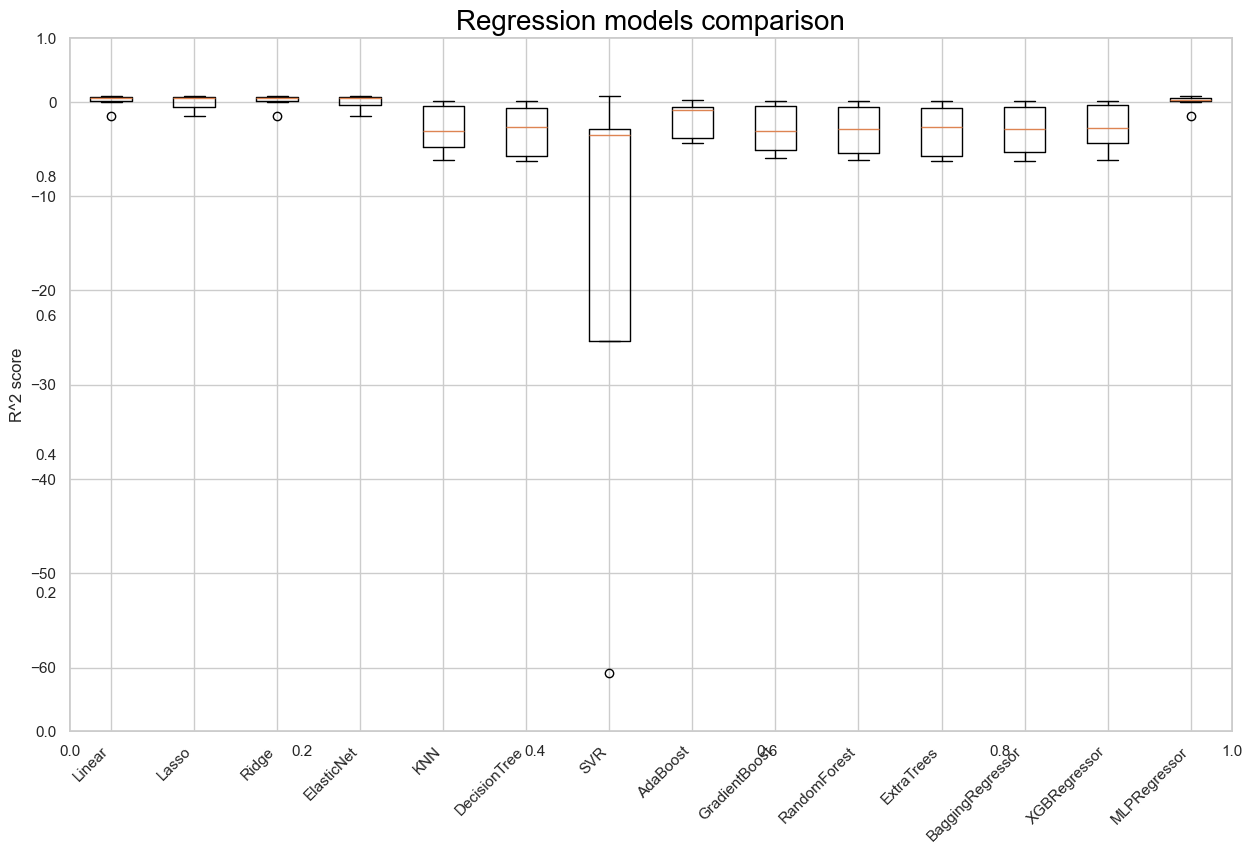

In [69]:
# Compare algorithms  

def box_compare():
  sns.set(rc={'figure.figsize':(15, 9)})
  sns.set_style(style='whitegrid', )
  figure = plt.figure()
  plt.title('Regression models comparison', color = 'black', fontsize = 20)
  axis = figure.add_subplot(111)
  plt.boxplot(model_results)
  axis.set_xticklabels(model_names, rotation = 45, ha="right")
  axis.set_ylabel("R^2 score")
  plt.margins(0.05, 0.1)

box_compare()
     

In [70]:
# Create Linear Regression model
lr = LinearRegression()

# Train the model
lr.fit(X_train, y_train)# Create Linear Regression model
lr = LinearRegression()

# Train the model
lr.fit(X_train, y_train)

LinearRegression()

In [71]:

# Make predictions using the model
predictions = lr.predict(X_test)

In [72]:

# The coefficients
print('Coefficients: ', lr.coef_)
# The mean squared error
print('RMSE: {}'.format(round(mean_squared_error(y_test, predictions, squared=False), 3)))
# Explained variance score: 1 is perfect prediction, 0 is random
print('R^2 score: {}'.format(round(r2_score(y_test, predictions), 3)))

Coefficients:  [1.01786332]
RMSE: 12.93
R^2 score: 0.671


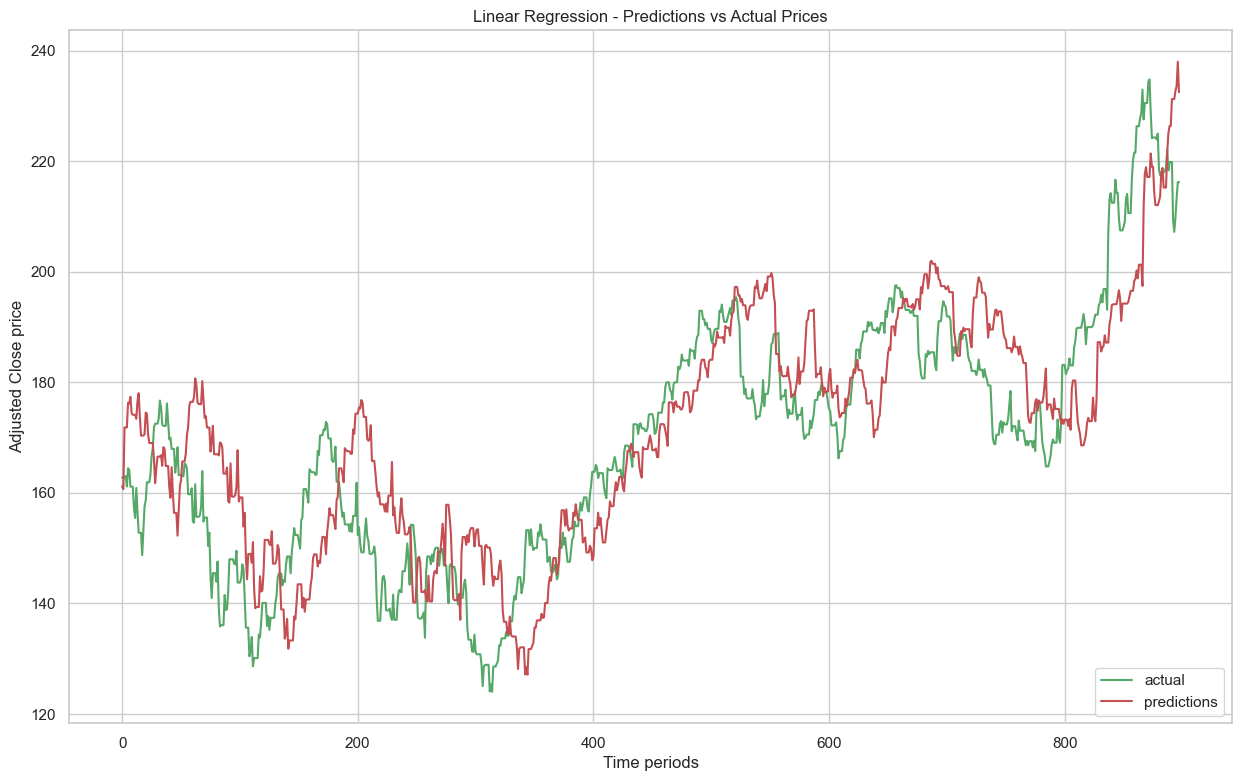

In [73]:
# Plot predictions against actual Adjusted Close prices 

x_axis = np.array(range(0, predictions.shape[0]))
plt.plot(x_axis, y_test, color='g', label="actual")
plt.plot(x_axis, predictions, color='r', label="predictions")
plt.xlabel('Time periods')
plt.ylabel('Adjusted Close price')
plt.title('Linear Regression - Predictions vs Actual Prices')
plt.legend(loc='lower right')
plt.show()

In [74]:
pd.DataFrame({"Actual": y_test, "Predict": predictions}).head()


,Actual,Predict
0,162.767,161.155052
1,162.767,160.682763
2,162.767,171.834474
3,163.033,171.834474
4,161.138,171.834474


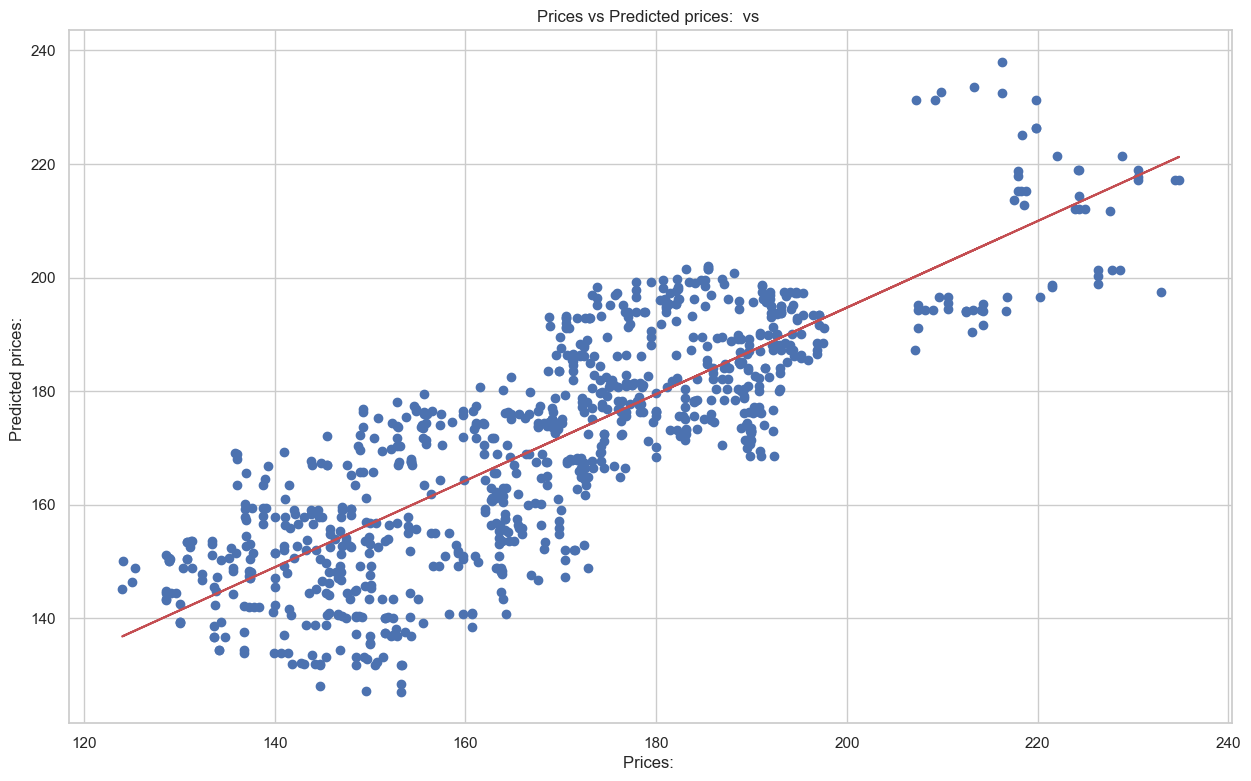

In [75]:
# create basic scatterplot
plt.scatter(y_test,predictions)

# obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(y_test, predictions, 1)

# add linear regression line to scatterplot 
plt.plot(y_test, m*y_test+b, c='r')

plt.xlabel("Prices: ")
plt.ylabel("Predicted prices: ")
plt.title("Prices vs Predicted prices:  vs ")
plt.show()
     

In [76]:
# Predicted prices

lr_prediction = lr.predict(X_forecast)
print(lr_prediction)

[235.52828901 235.52828901 235.52828901 239.45724143 239.88474402
 233.8386359  229.0546783  229.18700053 229.18700053 229.18700053
 228.83074837 229.89950486 223.31392918 222.24517269 222.72356845
 222.72356845 222.72356845 223.00857018 223.57857364 226.91716533
 223.13071378 224.65750876 224.65750876 224.65750876 213.87833621
 211.80189504 214.43816103 217.99050402 220.97284354 220.97284354]


In [77]:
# Actual prices

X_forecast

array([[230.54],
       [230.54],
       [230.54],
       [234.4 ],
       [234.82],
       [228.88],
       [224.18],
       [224.31],
       [224.31],
       [224.31],
       [223.96],
       [225.01],
       [218.54],
       [217.49],
       [217.96],
       [217.96],
       [217.96],
       [218.24],
       [218.8 ],
       [222.08],
       [218.36],
       [219.86],
       [219.86],
       [219.86],
       [209.27],
       [207.23],
       [209.82],
       [213.31],
       [216.24],
       [216.24]])

In [78]:

# The coefficients
print('Coefficients: ', lr.coef_)
# The mean squared error
print('RMSE: {}'.format(round(mean_squared_error(X_forecast, lr_prediction, squared=False), 3)))
# Explained variance score: 1 is perfect prediction, 0 is random
print('R^2 score: {}'.format(round(r2_score(X_forecast, lr_prediction), 3)))

Coefficients:  [1.01786332]
RMSE: 4.822
R^2 score: 0.502


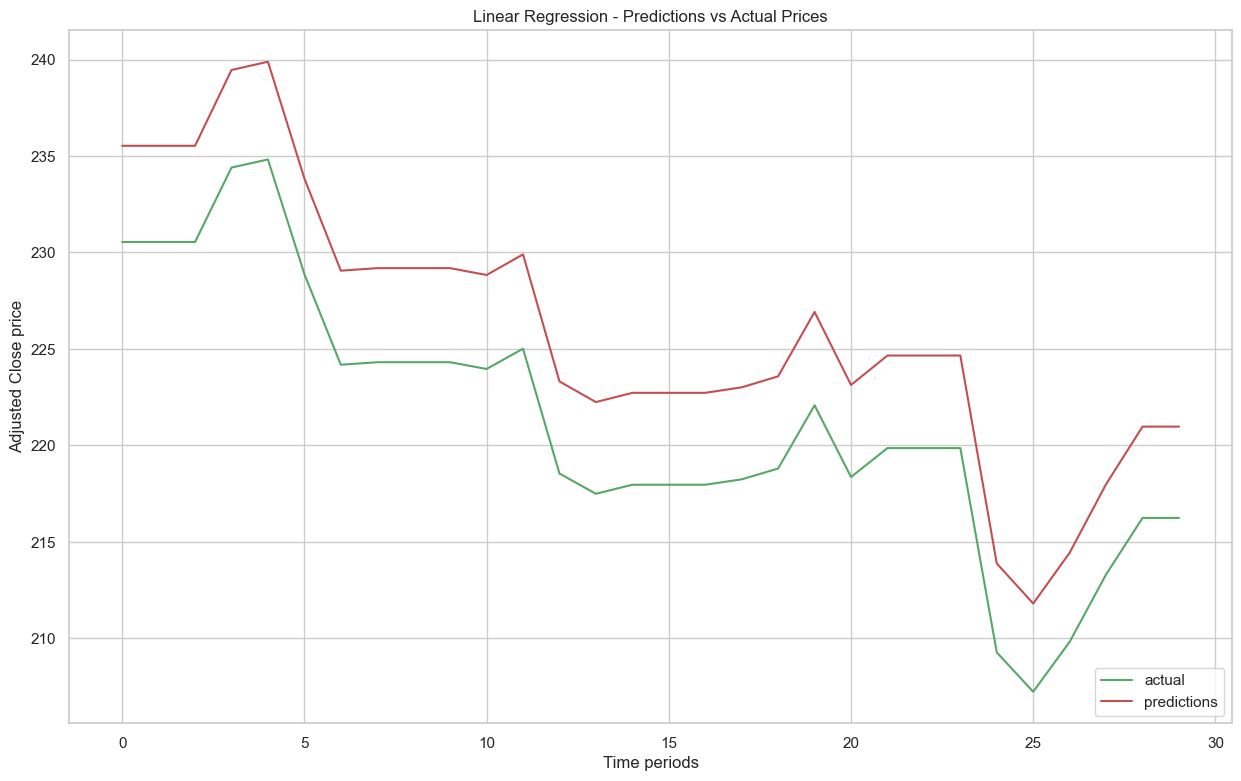

In [79]:
# Plot predictions against actual Adjusted Close prices 

x_axis = np.array(range(0, lr_prediction.shape[0]))
plt.plot(x_axis, X_forecast, color='g', label="actual")
plt.plot(x_axis, lr_prediction, color='r', label="predictions")
plt.xlabel('Time periods')
plt.ylabel('Adjusted Close price')
plt.title('Linear Regression - Predictions vs Actual Prices')
plt.legend(loc='lower right')
plt.show()

In [80]:
# Reshape data to be 1D
X_forecast = X_forecast.reshape(-1)
X_forecast 

array([230.54, 230.54, 230.54, 234.4 , 234.82, 228.88, 224.18, 224.31,
       224.31, 224.31, 223.96, 225.01, 218.54, 217.49, 217.96, 217.96,
       217.96, 218.24, 218.8 , 222.08, 218.36, 219.86, 219.86, 219.86,
       209.27, 207.23, 209.82, 213.31, 216.24, 216.24])

In [81]:
pd.DataFrame({"Actual": X_forecast, "Predict": lr_prediction}).head()


,Actual,Predict
0,230.54,235.528289
1,230.54,235.528289
2,230.54,235.528289
3,234.40,239.457241
4,234.82,239.884744


In [82]:
# Hyper parameter optimisation

In [83]:
# Create dictionary of parameters
parameters = { 'fit_intercept': [True, False],
         'n_jobs': [None, -1]}

In [84]:
# Grid search to find best parameters
gridsearchcv_lr = GridSearchCV(estimator=lr, param_grid=parameters, cv=tscv, scoring='r2')
grid_result_lr = gridsearchcv_lr.fit(X_train, y_train)
print("Best: {} using {}".format(grid_result_lr.best_score_, grid_result_lr.best_params_))

Best: 0.19555417455791727 using {'fit_intercept': False, 'n_jobs': None}


In [85]:
# All of the best parameters for the optimal model

best_model_lr = grid_result_lr.best_estimator_
print(f"Best model has the following hyperparameters: {best_model_lr}")

Best model has the following hyperparameters: LinearRegression(fit_intercept=False)


In [86]:
# Reshape data to be 2D
X_forecast = X_forecast.reshape(-1,1)
X_forecast

array([[230.54],
       [230.54],
       [230.54],
       [234.4 ],
       [234.82],
       [228.88],
       [224.18],
       [224.31],
       [224.31],
       [224.31],
       [223.96],
       [225.01],
       [218.54],
       [217.49],
       [217.96],
       [217.96],
       [217.96],
       [218.24],
       [218.8 ],
       [222.08],
       [218.36],
       [219.86],
       [219.86],
       [219.86],
       [209.27],
       [207.23],
       [209.82],
       [213.31],
       [216.24],
       [216.24]])

In [87]:
# Create Linear Regression model
lr = LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None)

# Train the model using the training sets
lr.fit(X_train, y_train)

# Make predictions using the model
predictions = lr.predict(X_forecast)


# The coefficients
print('Coefficients: ', lr.coef_)
# The mean squared error
print('RMSE: {}'.format(round(mean_squared_error(X_forecast, predictions, squared=False), 3)))
# Explained variance score: 1 is perfect prediction, 0 is random
print('R^2 score: {}'.format(round(r2_score(X_forecast, predictions), 3)))

Coefficients:  [1.02709488]
RMSE: 5.995
R^2 score: 0.23


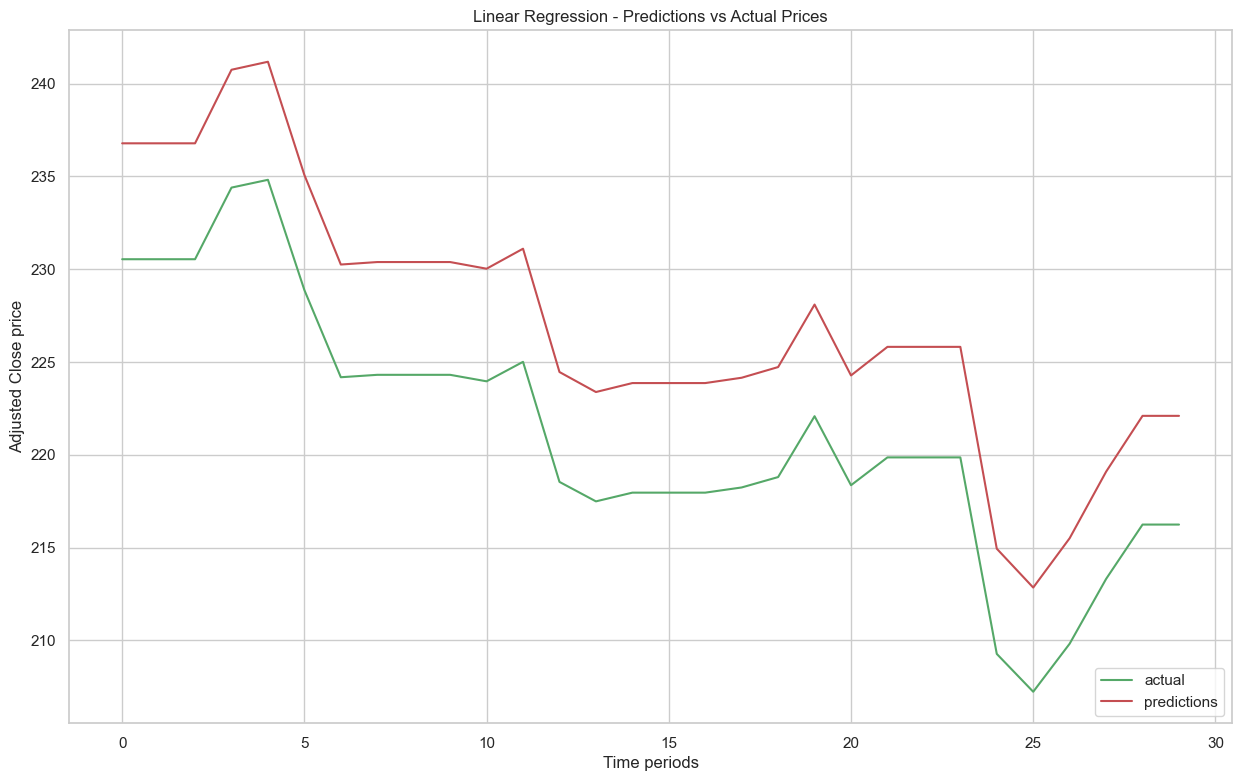

In [88]:
# Plot predictions against actual Adjusted Close prices  

x_axis = np.array(range(0, predictions.shape[0]))
plt.plot(x_axis, X_forecast, color='g', label="actual")
plt.plot(x_axis, predictions, color='r', label="predictions")
plt.xlabel('Time periods')
plt.ylabel('Adjusted Close price')
plt.title('Linear Regression - Predictions vs Actual Prices')
plt.legend(loc='lower right')
plt.show()

In [89]:
# MLP regressor

In [90]:

# Create an MLP Regressor model  
mlpr = MLPRegressor(max_iter=500, solver = 'lbfgs')

# Train the model using the training sets
mlpr.fit(X_train, y_train)
mlpr

MLPRegressor(max_iter=500, solver='lbfgs')

In [91]:

# Make predictions using the model
predictions = mlpr.predict(X_test)

In [92]:
# The mean squared error
print('RMSE: {}'.format(round(mean_squared_error(y_test, predictions, squared=False), 3)))
# Explained variance score: 1 is perfect prediction, 0 is random
print('R^2 score: {}'.format(round(r2_score(y_test, predictions), 3)))

RMSE: 12.93
R^2 score: 0.671


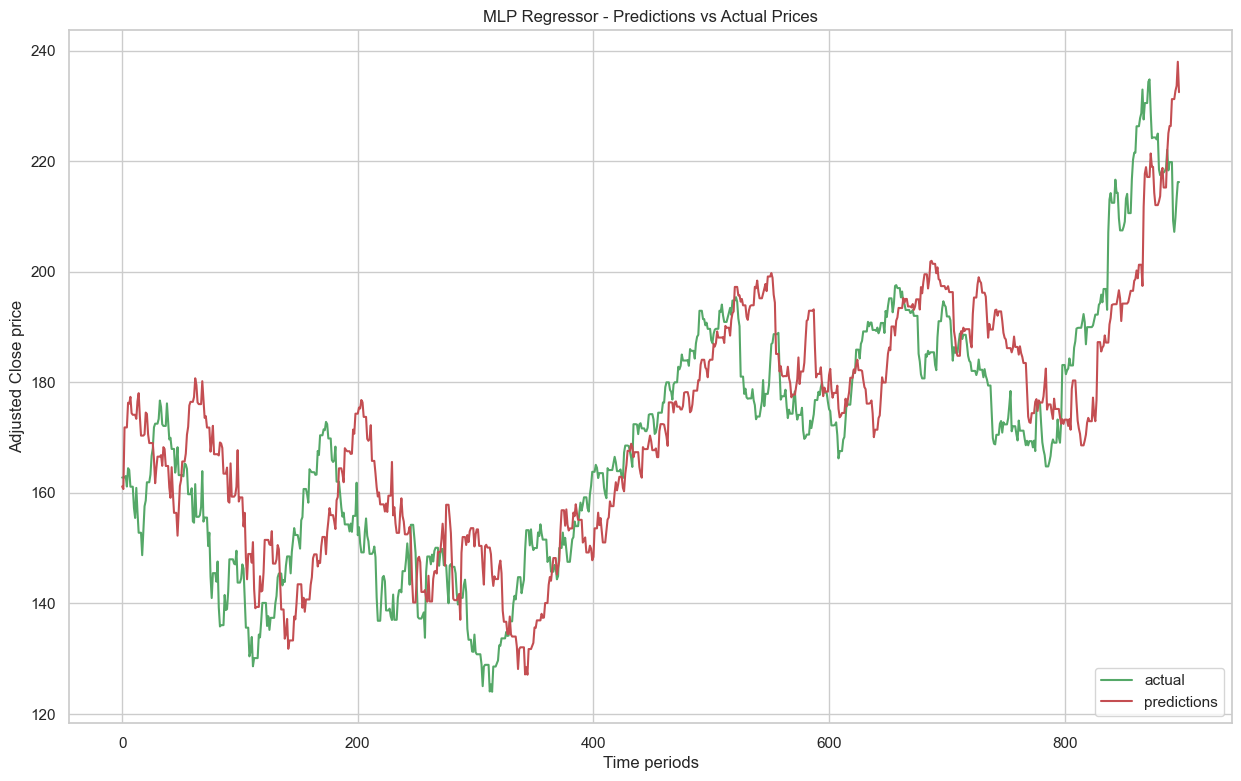

In [93]:
# Plot predictions against actual Adjusted Close prices 

x_axis = np.array(range(0, predictions.shape[0]))
plt.plot(x_axis, y_test, color='g', label="actual")
plt.plot(x_axis, predictions, color='r', label="predictions")
plt.xlabel('Time periods')
plt.ylabel('Adjusted Close price')
plt.title('MLP Regressor - Predictions vs Actual Prices')
plt.legend(loc='lower right')
plt.show()

In [94]:
pd.DataFrame({"Actual": y_test, "Predict": predictions}).head()

,Actual,Predict
0,162.767,161.155052
1,162.767,160.682764
2,162.767,171.834474
3,163.033,171.834474
4,161.138,171.834474


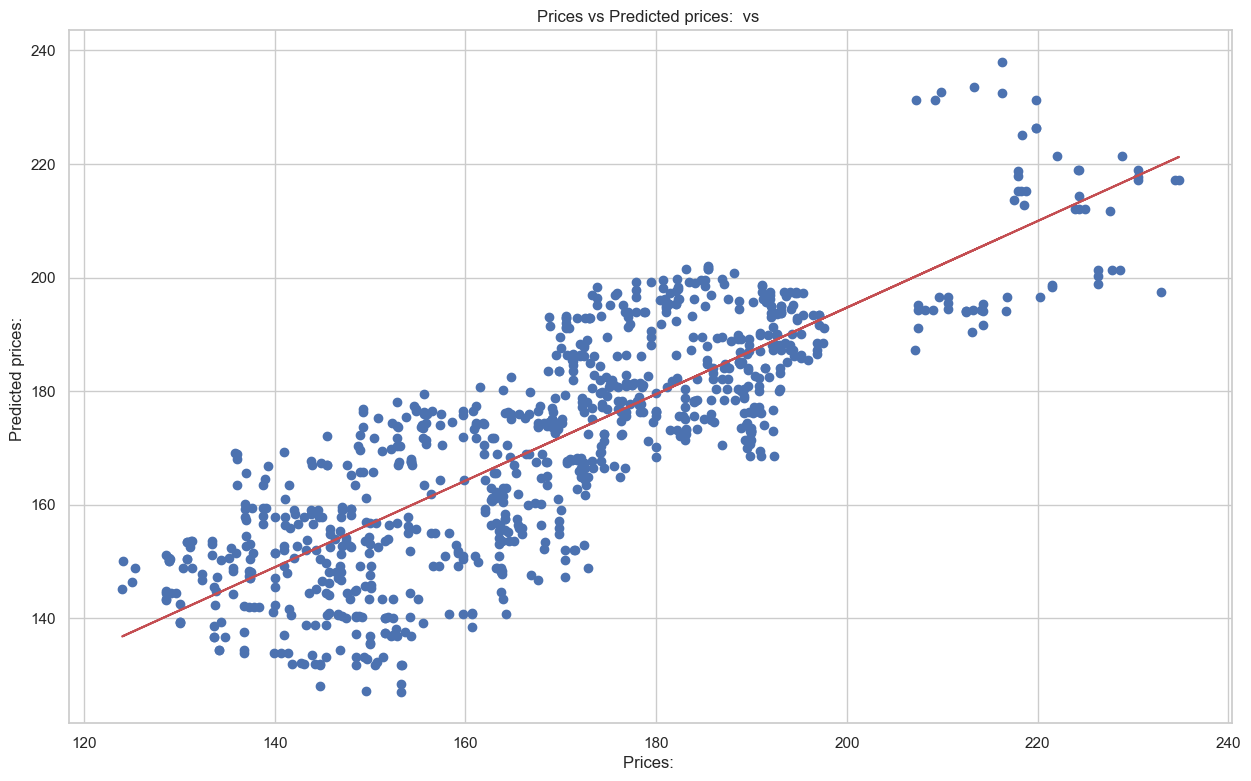

In [95]:
# create basic scatterplot
plt.scatter(y_test,predictions)

# obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(y_test, predictions, 1)

# add linear regression line to scatterplot 
plt.plot(y_test, m*y_test+b, c='r')

plt.xlabel("Prices: ")
plt.ylabel("Predicted prices: ")
plt.title("Prices vs Predicted prices:  vs ")
plt.show()

In [96]:
# Predicted prices

mlpr_prediction = mlpr.predict(X_forecast)
print(mlpr_prediction)

[235.52828948 235.52828948 235.52828948 239.4572419  239.88474449
 233.83863637 229.05467876 229.18700099 229.18700099 229.18700099
 228.83074883 229.89950532 223.31392964 222.24517315 222.72356891
 222.72356891 222.72356891 223.00857064 223.5785741  226.91716579
 223.13071424 224.65750922 224.65750922 224.65750922 213.87833665
 211.80189548 214.43816148 217.99050447 220.972844   220.972844  ]


In [97]:
X_forecast

array([[230.54],
       [230.54],
       [230.54],
       [234.4 ],
       [234.82],
       [228.88],
       [224.18],
       [224.31],
       [224.31],
       [224.31],
       [223.96],
       [225.01],
       [218.54],
       [217.49],
       [217.96],
       [217.96],
       [217.96],
       [218.24],
       [218.8 ],
       [222.08],
       [218.36],
       [219.86],
       [219.86],
       [219.86],
       [209.27],
       [207.23],
       [209.82],
       [213.31],
       [216.24],
       [216.24]])

In [98]:
# The mean squared error
print('RMSE: {}'.format(round(mean_squared_error(X_forecast, mlpr_prediction, squared=False), 3)))
# Explained variance score: 1 is perfect prediction, 0 is random
print('R^2 score: {}'.format(round(r2_score(X_forecast, mlpr_prediction), 3)))

RMSE: 4.822
R^2 score: 0.502


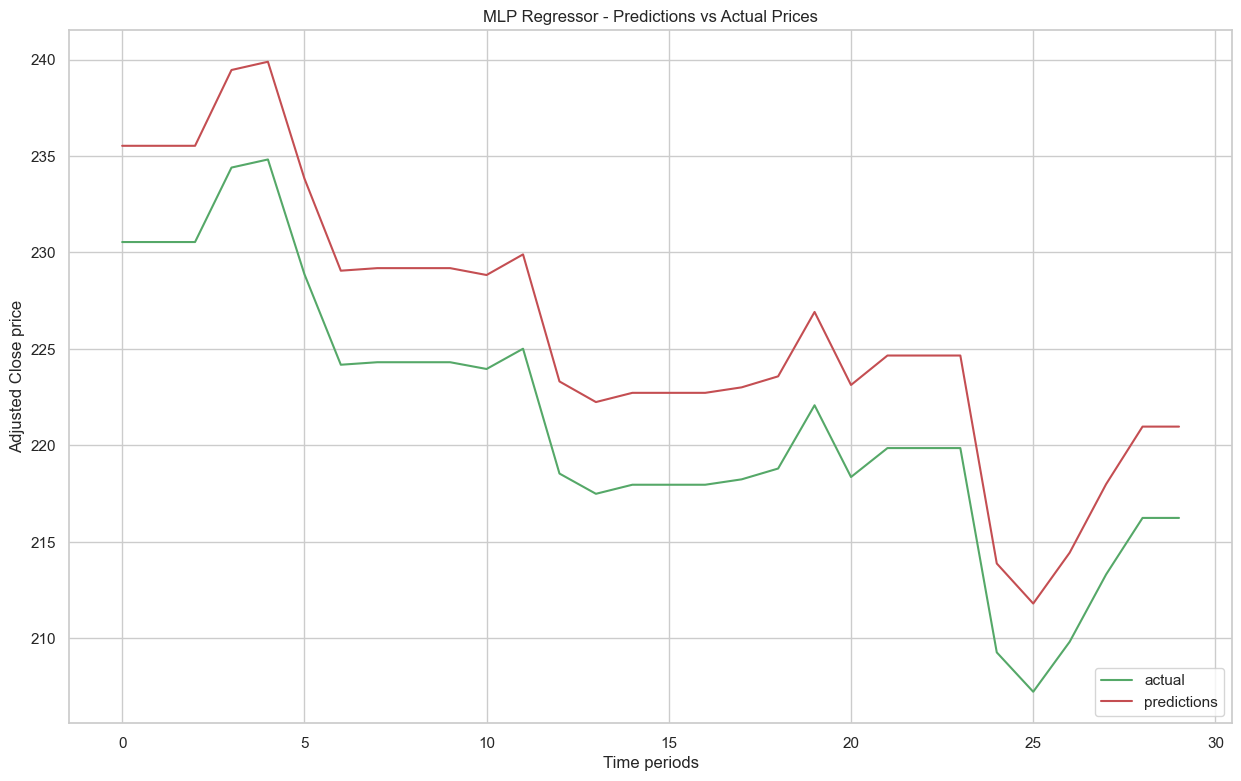

In [99]:
# Plot predictions against actual Adjusted Close prices 

x_axis = np.array(range(0, mlpr_prediction.shape[0]))
plt.plot(x_axis, X_forecast, color='g', label="actual")
plt.plot(x_axis, mlpr_prediction, color='r', label="predictions")
plt.xlabel('Time periods')
plt.ylabel('Adjusted Close price')
plt.title('MLP Regressor - Predictions vs Actual Prices')
plt.legend(loc='lower right')
plt.show()

In [100]:
# Reshape data to be 1D
X_forecast = X_forecast.reshape(-1)

In [101]:
pd.DataFrame({"Actual": X_forecast, "Predict": mlpr_prediction}).head()

,Actual,Predict
0,230.54,235.528289
1,230.54,235.528289
2,230.54,235.528289
3,234.40,239.457242
4,234.82,239.884744


In [102]:
# Reshape data as this needs to be 2D
y_train = y_train.reshape(-1, 1)

In [103]:
# Normalise data to improve convergence

scaler = MinMaxScaler(feature_range=(0, 1))
X_train_norm = scaler.fit_transform(X_train)
y_train_norm = scaler.transform(y_train)
X_test_norm = scaler.transform(X_test)

In [104]:
# Create model

mlpr = MLPRegressor(max_iter=500)

In [105]:
# Create dictionary of parameters to iterate over

parameters = {"hidden_layer_sizes": [(50,50,50), (50,100,50), (100,)],
              "activation": ["identity", "logistic", "tanh", "relu"], 
              "solver": ["lbfgs", "sgd", "adam"], 
              "alpha": [0.0001, 0.05], 
              "learning_rate": ['constant','adaptive']}

In [ ]:
# Grid search to find best parameters

gridsearchcv_mlpr = GridSearchCV(estimator=mlpr, param_grid=parameters, cv=tscv, scoring='r2')
grid_result_mlpr = gridsearchcv_mlpr.fit(X_train_norm, y_train_norm)
print("Best: {} using {}".format(grid_result_mlpr.best_score_, grid_result_mlpr.best_params_))

In [ ]:
# All of the best parameters for the optimal model  

best_model_mlpr = grid_result_mlpr.best_estimator_
print(f"Best model has the following hyperparameters: {best_model_mlpr}")

In [ ]:
# Reshape data to be 2D
X_forecast = X_forecast.reshape(-1,1)
X_forecast

In [ ]:
# Create MLP Regression model  
mlpr = MLPRegressor(activation='relu', alpha=0.05, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100,), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=500,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=None, shuffle=True, solver='lbfgs',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)

# Train the model using the training sets
mlpr.fit(X_train, y_train)

# Make predictions using the model
predictions = mlpr.predict(X_forecast)

# The mean squared error
print('RMSE: {}'.format(round(mean_squared_error(X_forecast, predictions, squared=False), 3)))
# Explained variance score: 1 is perfect prediction, 0 is random
print('R^2 score: {}'.format(round(r2_score(X_forecast, predictions), 3)))
     

In [ ]:
# Plot predictions against actual Adjusted Close prices

x_axis = np.array(range(0, predictions.shape[0]))
plt.plot(x_axis, X_forecast, color='g', label="actual")
plt.plot(x_axis, predictions, color='r', label="predictions")
plt.xlabel('Time periods')
plt.ylabel('Adjusted Close price')
plt.title('MLP Regressor - Predictions vs Actual Prices')
plt.legend(loc='lower right')
plt.show()
     